<a href="https://colab.research.google.com/github/RochaErik/AlgorithmComparison/blob/main/AlgorithmComparison3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# **Evaluating algorithms with hyperparameter tuning**

---

In [1]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import scipy.stats as stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [3]:
!pip install hyperopt

In [4]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# **Wine Dataset**

In [5]:
wine_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\AprendizadoDeMaquina\Seminario\Datasets\Wine\wine.data', header=None)

In [6]:
# X = wine_df.iloc[:, 1:]
# y = wine_df.iloc[:, 0]

In [7]:
# le = LabelEncoder()
# y = le.fit_transform(wine_df)

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
train_ratio = 0.6  # 60% for training
val_ratio = 0.2    # 20% for validation
test_ratio = 0.2   # 20% for testing

# First, split the data into training and temporary sets
temp_data, test_data = train_test_split(wine_df, test_size=test_ratio, random_state=42)

# Then, split the temporary data into training and validation sets
train_data, val_data = train_test_split(temp_data, test_size=val_ratio / (1 - test_ratio), random_state=42)

# Now, you have your training, validation, and test sets
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (106, 14)
Validation data shape: (36, 14)
Test data shape: (36, 14)


In [10]:
# Training
X_train = train_data.iloc[:, 1:]
y_train = train_data.iloc[:, 0]
print(f"Training data shape: {X_train.shape, y_train.shape}")

# Validation
X_val = val_data.iloc[:, 1:]
y_val = val_data.iloc[:, 0]
print(f"Validation data shape: {X_val.shape, y_val.shape}")

# Test
X_test = test_data.iloc[:, 1:]
y_test = test_data.iloc[:, 0]
print(f"Test data shape: {X_test.shape, y_test.shape}")

Training data shape: ((106, 13), (106,))
Validation data shape: ((36, 13), (36,))
Test data shape: ((36, 13), (36,))


In [11]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)

In [12]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

100%|██████████| 50/50 [00:22<00:00,  2.23trial/s, best loss: -1.0]               
Best hyperparameters for AdaBoost:
{'n_estimators': 50.0, 'learning_rate': 0.03569852905094406, 'max_depth': 6.0, 'max_features': 'sqrt', 'min_samples_leaf': 2.0, 'min_samples_split': 2.0, 'random_state': 42}
100%|██████████| 50/50 [01:15<00:00,  1.52s/trial, best loss: -0.9722222222222222]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': None, 'n_estimators': 750, 'learning_rate': 0.08767165012042817, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0, 'min_impurity_decrease': 1.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [01:34<00:00,  1.90s/trial, best loss: -0.9444444444444444]
Best hyperparameters for CatBoost:
{'n_estimators': 550, 'learning_rate': 0.0479901225935416, 'min_child_samples': 1, 'max_depth': 6, 'reg_lambda': 3.3766279624518107, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 [00:

In [13]:
best_hyperparams['AdaBoost']

{'n_estimators': 50.0,
 'learning_rate': 0.03569852905094406,
 'max_depth': 6.0,
 'max_features': 'sqrt',
 'min_samples_leaf': 2.0,
 'min_samples_split': 2.0,
 'random_state': 42}

In [14]:
best_hyperparams['GradBoost']

{'criterion': 'friedman_mse',
 'max_features': None,
 'n_estimators': 750,
 'learning_rate': 0.08767165012042817,
 'max_depth': 2,
 'min_samples_split': 3,
 'min_samples_leaf': 6,
 'min_weight_fraction_leaf': 0.0,
 'min_impurity_decrease': 1.0,
 'ccp_alpha': 0.0,
 'random_state': 42}

In [15]:
best_hyperparams['CatBoost']

{'n_estimators': 550,
 'learning_rate': 0.0479901225935416,
 'min_child_samples': 1,
 'max_depth': 6,
 'reg_lambda': 3.3766279624518107,
 'silent': True,
 'random_state': 42}

In [16]:
best_hyperparams['LightGBM']

{'class_weight': 'balanced',
 'boosting_type': 'goss',
 'num_leaves': 50,
 'learning_rate': 0.04565607244585249,
 'min_child_samples': 30,
 'reg_alpha': 1.6427345495548966,
 'reg_lambda': 2.054240212545051,
 'colsample_by_tree': 0.2226952960698365,
 'verbosity': -1,
 'random_state': 42}

In [17]:
best_hyperparams['XGBoost']

{'booster': 'dart',
 'learning_rate': 0.09292666170093178,
 'gamma': 4,
 'max_depth': 4,
 'min_child_weight': 1,
 'colsample_bytree': 0.8943278668489419,
 'colsample_bylevel': 0.2640104690942444,
 'colsample_bynode': 0.8937107554719765,
 'reg_alpha': 0.056770729092546546,
 'reg_lambda': 4.219736540591216,
 'random_state': 42}

In [18]:
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [19]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [20]:
wine_scores = []
wine_scores_mean = []
wine_scores_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)
        
    start_time = time.time()    
    results = cross_val_score(clf, X_test, y_test, cv=rkf)
    end_time = time.time()
    wine_scores.append(results)
    wine_scores_mean.append(results.mean()*100)
    wine_scores_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)

    print(f'--------- {algorithm_name} on Wine Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on Wine Dataset ---------
[1.         1.         1.         1.         0.75       0.75
 1.         0.66666667 1.         1.         1.         1.
 0.75       1.         0.75       1.         1.         0.66666667
 0.66666667 1.         1.         1.         0.5        1.
 0.25       1.         0.33333333 1.         1.         1.
 1.         1.         1.         0.75       1.         1.
 1.         0.66666667 1.         1.         1.         1.
 0.5        0.75       0.5        1.         0.66666667 0.66666667
 1.         1.         0.75       1.         1.         1.
 0.75       0.75       0.66666667 1.         1.         1.
 1.         0.75       0.5        1.         1.         1.
 0.66666667 0.66666667 1.         1.         0.75       0.75
 1.         0.75       1.         1.         1.         1.
 1.         1.         1.         0.5        1.         1.
 0.75       1.         0.66666667 1.         1.         0.66666667
 1.         0.75       1.         0.75    

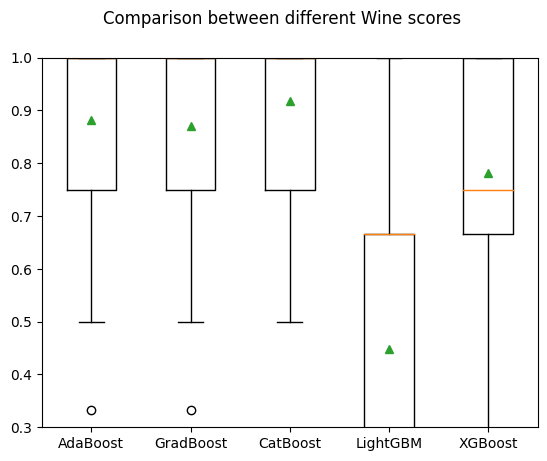

In [21]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Wine scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(wine_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [22]:
Algo_results = pd.DataFrame()
Algo_results['Names'] = names

In [23]:
Algo_results['Wine'] = wine_scores_mean

In [24]:
Algo_results

,Names,Wine
0,AdaBoost,88.166667
1,GradBoost,87.000000
2,CatBoost,91.750000
3,LightGBM,44.916667
4,XGBoost,78.250000


In [25]:
Algo_time_results = pd.DataFrame()
Algo_time_results['Names'] = names

In [26]:
Algo_time_results['Wine'] = pd.Series(execution_times)

In [27]:
Algo_time_results

,Names,Wine
0,AdaBoost,1.013227
1,GradBoost,98.996717
2,CatBoost,53.566599
3,LightGBM,0.755169
4,XGBoost,17.993899


---

# **Breast Cancer Dataset**

---

In [28]:
breast_cancer_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\AprendizadoDeMaquina\Seminario\Datasets\BreastCancer\Breast.dat', sep=',', header=None)

In [29]:
train_ratio = 0.6  # 60% for training
val_ratio = 0.2    # 20% for validation
test_ratio = 0.2   # 20% for testing

# First, split the data into training and temporary sets
temp_data, test_data = train_test_split(breast_cancer_df, test_size=test_ratio, random_state=42)

# Then, split the temporary data into training and validation sets
train_data, val_data = train_test_split(temp_data, test_size=val_ratio / (1 - test_ratio), random_state=42)

# Now, you have your training, validation, and test sets
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (409, 10)
Validation data shape: (137, 10)
Test data shape: (137, 10)


In [30]:
# Training
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
print(f"Training data shape: {X_train.shape, y_train.shape}")

# Validation
X_val = val_data.iloc[:, :-1]
y_val = val_data.iloc[:, -1]
print(f"Validation data shape: {X_val.shape, y_val.shape}")

# Test
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]
print(f"Test data shape: {X_test.shape, y_test.shape}")

Training data shape: ((409, 9), (409,))
Validation data shape: ((137, 9), (137,))
Test data shape: ((137, 9), (137,))


In [31]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)

In [32]:
# X = breast_cancer_df.iloc[:, :-1]
# y = breast_cancer_df.iloc[:, -1]

In [33]:
# # Since version 1.3.2 XGBoost needs target columns to start with 0 value

# le = LabelEncoder()
# y = le.fit_transform(y)

In [34]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

100%|██████████| 50/50 [00:39<00:00,  1.26trial/s, best loss: -0.9854014598540146]
Best hyperparameters for AdaBoost:
{'n_estimators': 300.0, 'learning_rate': 0.03187156794580643, 'max_depth': 2.0, 'max_features': 'sqrt', 'min_samples_leaf': 3.0, 'min_samples_split': 2.0, 'random_state': 42}
100%|██████████| 50/50 [00:15<00:00,  3.22trial/s, best loss: -0.9781021897810219]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': 'sqrt', 'n_estimators': 350, 'learning_rate': 0.02169498620711493, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.30000000000000004, 'min_impurity_decrease': 1.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [01:01<00:00,  1.22s/trial, best loss: -0.9781021897810219]
Best hyperparameters for CatBoost:
{'n_estimators': 1350, 'learning_rate': 0.022260180099049558, 'min_child_samples': 9, 'max_depth': 10, 'reg_lambda': 2.3890620775373677, 'silent': True, 'random_state': 42}
100%

In [36]:
best_hyperparams['AdaBoost']

{'n_estimators': 300.0,
 'learning_rate': 0.03187156794580643,
 'max_depth': 2.0,
 'max_features': 'sqrt',
 'min_samples_leaf': 3.0,
 'min_samples_split': 2.0,
 'random_state': 42}

In [37]:
best_hyperparams['GradBoost']

{'criterion': 'friedman_mse',
 'max_features': 'sqrt',
 'n_estimators': 350,
 'learning_rate': 0.02169498620711493,
 'max_depth': 2,
 'min_samples_split': 3,
 'min_samples_leaf': 7,
 'min_weight_fraction_leaf': 0.30000000000000004,
 'min_impurity_decrease': 1.0,
 'ccp_alpha': 0.0,
 'random_state': 42}

In [38]:
best_hyperparams['CatBoost']

{'n_estimators': 1350,
 'learning_rate': 0.022260180099049558,
 'min_child_samples': 9,
 'max_depth': 10,
 'reg_lambda': 2.3890620775373677,
 'silent': True,
 'random_state': 42}

In [39]:
best_hyperparams['LightGBM']

{'class_weight': 'balanced',
 'boosting_type': 'dart',
 'num_leaves': 65,
 'learning_rate': 0.05159022361237221,
 'min_child_samples': 80,
 'reg_alpha': 0.8515154151071994,
 'reg_lambda': 1.6452421725389161,
 'colsample_by_tree': 0.11325175413854531,
 'verbosity': -1,
 'random_state': 42}

In [40]:
best_hyperparams['XGBoost']

{'booster': 'dart',
 'learning_rate': 0.028333773798751113,
 'gamma': 7,
 'max_depth': 3,
 'min_child_weight': 3,
 'colsample_bytree': 0.35891611046647764,
 'colsample_bylevel': 0.4525159458882072,
 'colsample_bynode': 0.5248347077120967,
 'reg_alpha': 0.5515570000191785,
 'reg_lambda': 0.6777375007659625,
 'random_state': 42}

In [41]:
breast_cancer_scores = []
breast_cancer_mean = []
breast_cancer_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)

    start_time = time.time()    
    results = cross_val_score(clf, X_test, y_test, cv=rskf)
    end_time = time.time()
    breast_cancer_scores.append(results)
    breast_cancer_mean.append(results.mean()*100)
    breast_cancer_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)

    print(f'--------- {algorithm_name} on Breast Cancer Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on Breast Cancer Dataset ---------
[1.         1.         0.92857143 0.92857143 1.         1.
 1.         1.         0.92307692 1.         0.92857143 0.92857143
 1.         0.92857143 1.         0.92857143 1.         0.92307692
 1.         1.         1.         1.         1.         1.
 0.92857143 0.92857143 0.92857143 0.92307692 1.         0.92307692
 0.92857143 1.         1.         1.         1.         1.
 1.         1.         1.         0.92307692 1.         0.85714286
 1.         1.         0.92857143 0.92857143 1.         1.
 1.         0.92307692 0.92857143 1.         1.         1.
 1.         0.85714286 1.         1.         1.         1.
 1.         1.         1.         0.92857143 0.92857143 0.92857143
 1.         1.         1.         0.92307692 1.         0.92857143
 1.         0.92857143 1.         1.         0.92857143 1.
 1.         0.92307692 0.92857143 0.92857143 0.92857143 1.
 1.         1.         1.         0.92307692 0.92307692 1.
 1.         1

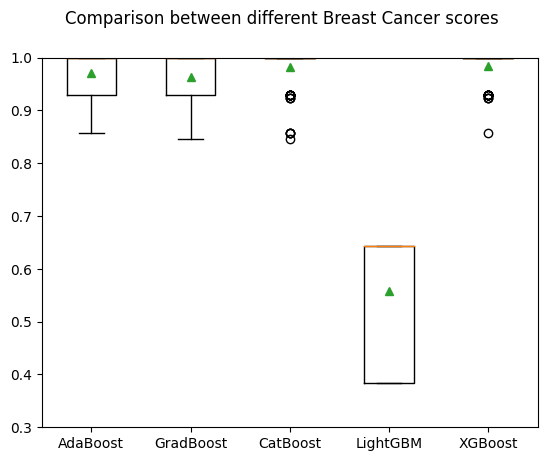

In [42]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Breast Cancer scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(breast_cancer_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [43]:
Algo_results['Breast_Cancer'] = breast_cancer_mean

In [44]:
Algo_results

,Names,Wine,Breast_Cancer
0,AdaBoost,88.166667,97.082418
1,GradBoost,87.000000,96.434066
2,CatBoost,91.750000,98.258242
3,LightGBM,44.916667,55.824176
4,XGBoost,78.250000,98.412088


In [45]:
Algo_time_results['Breast_Cancer'] = pd.Series(execution_times)

---

# **Sonar Dataset** #

---

In [46]:
sonar_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\AprendizadoDeMaquina\Seminario\Datasets\Sonar\Sonar.csv', header=None)

In [47]:
train_ratio = 0.6  # 60% for training
val_ratio = 0.2    # 20% for validation
test_ratio = 0.2   # 20% for testing

# First, split the data into training and temporary sets
temp_data, test_data = train_test_split(sonar_df, test_size=test_ratio, random_state=42)

# Then, split the temporary data into training and validation sets
train_data, val_data = train_test_split(temp_data, test_size=val_ratio / (1 - test_ratio), random_state=42)

# Now, you have your training, validation, and test sets
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (124, 61)
Validation data shape: (42, 61)
Test data shape: (42, 61)


In [48]:
# Training
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
print(f"Training data shape: {X_train.shape, y_train.shape}")

# Validation
X_val = val_data.iloc[:, :-1]
y_val = val_data.iloc[:, -1]
print(f"Validation data shape: {X_val.shape, y_val.shape}")

# Test
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]
print(f"Test data shape: {X_test.shape, y_test.shape}")

Training data shape: ((124, 60), (124,))
Validation data shape: ((42, 60), (42,))
Test data shape: ((42, 60), (42,))


In [49]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)

In [50]:
# X = sonar_df.iloc[:, :-1]
# y = sonar_df.iloc[:, -1]

In [51]:
# # Since version 1.3.2 XGBoost needs target columns to start with 0 value

# le = LabelEncoder()
# y = le.fit_transform(y)

In [52]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

100%|██████████| 50/50 [01:34<00:00,  1.89s/trial, best loss: -0.8809523809523809]
Best hyperparameters for AdaBoost:
{'n_estimators': 1500.0, 'learning_rate': 0.010450243715621818, 'max_depth': 3.0, 'max_features': 'log2', 'min_samples_leaf': 5.0, 'min_samples_split': 4.0, 'random_state': 42}
100%|██████████| 50/50 [01:13<00:00,  1.46s/trial, best loss: -0.8095238095238095]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': None, 'n_estimators': 750, 'learning_rate': 0.09835742587463962, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 0.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [02:06<00:00,  2.53s/trial, best loss: -0.8571428571428571]
Best hyperparameters for CatBoost:
{'n_estimators': 600, 'learning_rate': 0.029110730695044405, 'min_child_samples': 2, 'max_depth': 2, 'reg_lambda': 4.8671593597739, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 [

In [54]:
best_hyperparams['AdaBoost']

{'n_estimators': 1500.0,
 'learning_rate': 0.010450243715621818,
 'max_depth': 3.0,
 'max_features': 'log2',
 'min_samples_leaf': 5.0,
 'min_samples_split': 4.0,
 'random_state': 42}

In [55]:
best_hyperparams['GradBoost']

{'criterion': 'friedman_mse',
 'max_features': None,
 'n_estimators': 750,
 'learning_rate': 0.09835742587463962,
 'max_depth': 2,
 'min_samples_split': 3,
 'min_samples_leaf': 10,
 'min_weight_fraction_leaf': 0.1,
 'min_impurity_decrease': 0.0,
 'ccp_alpha': 0.0,
 'random_state': 42}

In [56]:
best_hyperparams['CatBoost']

{'n_estimators': 600,
 'learning_rate': 0.029110730695044405,
 'min_child_samples': 2,
 'max_depth': 2,
 'reg_lambda': 4.8671593597739,
 'silent': True,
 'random_state': 42}

In [57]:
best_hyperparams['LightGBM']

{'class_weight': 'balanced',
 'boosting_type': 'goss',
 'num_leaves': 95,
 'learning_rate': 0.07044945147979818,
 'min_child_samples': 10,
 'reg_alpha': 1.9914759381549856,
 'reg_lambda': 1.2771332838079967,
 'colsample_by_tree': 0.7974693873061367,
 'verbosity': -1,
 'random_state': 42}

In [58]:
best_hyperparams['XGBoost']

{'booster': 'gbtree',
 'learning_rate': 0.07407580593717424,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 5,
 'colsample_bytree': 0.9989873316558338,
 'colsample_bylevel': 0.5170842285607928,
 'colsample_bynode': 0.7621180610212037,
 'reg_alpha': 0.4015160144797284,
 'reg_lambda': 3.712557768424784,
 'random_state': 42}

In [59]:
sonar_scores = []
sonar_mean = []
sonar_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)
        
    start_time = time.time()
    results = cross_val_score(clf, X_test, y_test, cv=rskf)
    end_time = time.time()
    sonar_scores.append(results)
    sonar_mean.append(results.mean()*100)
    sonar_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)

    print(f'--------- {algorithm_name} on Sonar Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on Sonar Dataset ---------
[0.8  0.6  0.75 1.   0.5  1.   0.75 0.75 0.75 0.25 0.6  0.6  0.5  1.
 0.25 0.75 0.5  1.   0.75 0.75 0.8  0.8  0.75 0.75 0.75 0.5  1.   0.5
 0.5  0.5  0.6  1.   1.   0.5  0.75 0.75 0.5  0.5  0.5  1.   0.8  0.8
 0.5  1.   0.75 1.   0.75 0.75 0.75 0.25 0.6  0.8  1.   0.75 0.75 0.75
 0.5  0.75 0.75 0.5  1.   0.6  1.   0.5  0.25 0.5  0.75 0.75 0.75 0.75
 0.8  0.6  0.75 0.75 1.   0.75 0.25 1.   0.75 0.75 1.   0.8  0.75 0.75
 1.   0.5  0.5  0.5  0.5  0.5  0.8  0.6  0.5  1.   0.5  0.75 0.75 0.75
 0.75 0.5 ]
Accuracy: 70.25% (19.63%)
Execution Time: 172.10 seconds
------------------------------
--------- GradBoost on Sonar Dataset ---------
[0.8  0.8  1.   0.75 0.25 0.5  0.5  1.   1.   0.25 0.6  0.6  0.25 0.5
 0.25 0.5  0.25 0.5  0.75 0.5  0.6  0.6  0.25 0.75 0.5  0.5  0.5  0.5
 0.75 0.75 0.6  0.6  1.   0.25 0.75 0.75 0.5  0.5  0.5  1.   0.4  0.6
 0.5  1.   0.75 1.   0.75 0.5  0.75 0.5  0.6  0.8  0.75 0.5  0.75 0.75
 0.25 0.5  0.75 0.5  0.8  0.6  1.

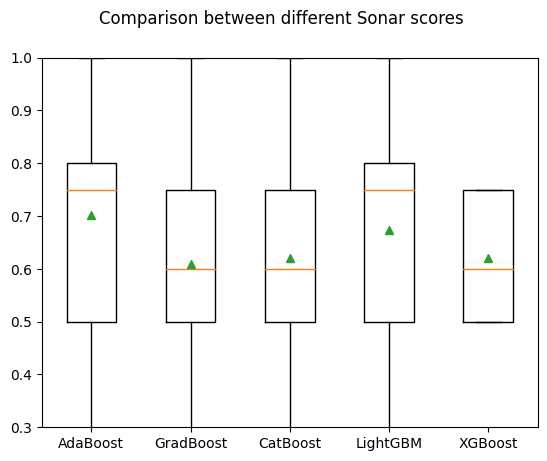

In [60]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Sonar scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(sonar_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [61]:
Algo_results['Sonar'] = sonar_mean

In [62]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar
0,AdaBoost,88.166667,97.082418,70.25
1,GradBoost,87.000000,96.434066,61.00
2,CatBoost,91.750000,98.258242,62.05
3,LightGBM,44.916667,55.824176,67.45
4,XGBoost,78.250000,98.412088,62.00


In [63]:
Algo_time_results['Sonar'] = pd.Series(execution_times)

---

# **Ionosphere Dataset**

---

In [64]:
ionosphere_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\AprendizadoDeMaquina\Seminario\Datasets\Ionosphere\ionosphere.data', header=None)

In [65]:
ionosphere_df.shape

(351, 35)

In [66]:
train_ratio = 0.6  # 60% for training
val_ratio = 0.2    # 20% for validation
test_ratio = 0.2   # 20% for testing

# First, split the data into training and temporary sets
temp_data, test_data = train_test_split(ionosphere_df, test_size=test_ratio, random_state=42)

# Then, split the temporary data into training and validation sets
train_data, val_data = train_test_split(temp_data, test_size=val_ratio / (1 - test_ratio), random_state=42)

# Now, you have your training, validation, and test sets
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (210, 35)
Validation data shape: (70, 35)
Test data shape: (71, 35)


In [67]:
# Training
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
print(f"Training data shape: {X_train.shape, y_train.shape}")

# Validation
X_val = val_data.iloc[:, :-1]
y_val = val_data.iloc[:, -1]
print(f"Validation data shape: {X_val.shape, y_val.shape}")

# Test
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]
print(f"Test data shape: {X_test.shape, y_test.shape}")

Training data shape: ((210, 34), (210,))
Validation data shape: ((70, 34), (70,))
Test data shape: ((71, 34), (71,))


In [68]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)

In [69]:
# X = ionosphere_df.iloc[:, :-1]
# y = ionosphere_df.iloc[:, -1]

In [70]:
# # Since version 1.3.2 XGBoost needs target columns to start with 0 value

# le = LabelEncoder()
# y = le.fit_transform(y)

In [71]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

100%|██████████| 50/50 [01:52<00:00,  2.25s/trial, best loss: -0.9714285714285714]
Best hyperparameters for AdaBoost:
{'n_estimators': 1200.0, 'learning_rate': 0.012995597957317272, 'max_depth': 5.0, 'max_features': 'sqrt', 'min_samples_leaf': 5.0, 'min_samples_split': 6.0, 'random_state': 42}
100%|██████████| 50/50 [01:04<00:00,  1.28s/trial, best loss: -0.9142857142857143]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': None, 'n_estimators': 850, 'learning_rate': 0.053611707225416305, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 0.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [02:19<00:00,  2.79s/trial, best loss: -0.9142857142857143]
Best hyperparameters for CatBoost:
{'n_estimators': 600, 'learning_rate': 0.029110730695044405, 'min_child_samples': 2, 'max_depth': 2, 'reg_lambda': 4.8671593597739, 'silent': True, 'random_state': 42}
100%|██████████| 50/50

In [73]:
ionosphere_scores = []
ionosphere_mean = []
ionosphere_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)
        
    start_time = time.time()    
    results = cross_val_score(clf, X_test, y_test, cv=rskf)
    end_time = time.time()
    ionosphere_scores.append(results)
    ionosphere_mean.append(results.mean()*100)
    ionosphere_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)
    print(f'--------- {algorithm_name} on Ionosphere Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on Ionosphere Dataset ---------
[0.875      0.85714286 1.         0.85714286 1.         0.71428571
 0.85714286 0.71428571 1.         0.85714286 0.875      1.
 0.71428571 0.71428571 0.85714286 0.71428571 0.85714286 0.85714286
 1.         1.         0.75       1.         1.         0.85714286
 0.85714286 1.         0.71428571 0.71428571 0.85714286 0.85714286
 1.         1.         0.85714286 0.85714286 0.85714286 0.85714286
 0.71428571 0.85714286 0.85714286 0.71428571 1.         0.85714286
 1.         0.85714286 0.85714286 0.71428571 0.85714286 0.71428571
 0.85714286 0.85714286 0.875      0.71428571 0.71428571 1.
 0.85714286 0.71428571 0.85714286 0.85714286 0.85714286 0.85714286
 0.875      0.85714286 0.85714286 0.71428571 0.85714286 1.
 0.85714286 0.85714286 0.85714286 0.71428571 0.75       0.85714286
 1.         0.85714286 1.         0.85714286 1.         0.71428571
 0.71428571 0.71428571 1.         1.         1.         0.57142857
 0.85714286 0.85714286 0.71428571 0

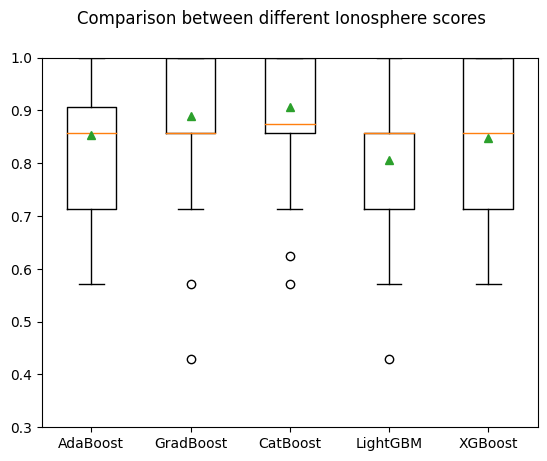

In [74]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Ionosphere scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(ionosphere_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [75]:
Algo_results['Ionosphere'] = ionosphere_mean

In [76]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere
0,AdaBoost,88.166667,97.082418,70.25,85.303571
1,GradBoost,87.000000,96.434066,61.00,88.928571
2,CatBoost,91.750000,98.258242,62.05,90.607143
3,LightGBM,44.916667,55.824176,67.45,80.714286
4,XGBoost,78.250000,98.412088,62.00,84.750000


In [77]:
Algo_time_results['Ionosphere'] = pd.Series(execution_times)

---

# **Bupa**

---

In [78]:
bupa_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\AprendizadoDeMaquina\Seminario\Datasets\Bupa\Bupa.data', header=None)

In [79]:
bupa_df.shape

(345, 7)

In [80]:
train_ratio = 0.6  # 60% for training
val_ratio = 0.2    # 20% for validation
test_ratio = 0.2   # 20% for testing

# First, split the data into training and temporary sets
temp_data, test_data = train_test_split(bupa_df, test_size=test_ratio, random_state=42)

# Then, split the temporary data into training and validation sets
train_data, val_data = train_test_split(temp_data, test_size=val_ratio / (1 - test_ratio), random_state=42)

# Now, you have your training, validation, and test sets
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (207, 7)
Validation data shape: (69, 7)
Test data shape: (69, 7)


In [81]:
# Training
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
print(f"Training data shape: {X_train.shape, y_train.shape}")

# Validation
X_val = val_data.iloc[:, :-1]
y_val = val_data.iloc[:, -1]
print(f"Validation data shape: {X_val.shape, y_val.shape}")

# Test
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]
print(f"Test data shape: {X_test.shape, y_test.shape}")

Training data shape: ((207, 6), (207,))
Validation data shape: ((69, 6), (69,))
Test data shape: ((69, 6), (69,))


In [82]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)

In [83]:
# X = bupa_df.iloc[:, :-1]
# y = bupa_df.iloc[:, -1]

In [84]:
# # Since version 1.3.2 XGBoost needs target columns to start with 0 value

# le = LabelEncoder()
# y = le.fit_transform(y)

In [85]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

100%|██████████| 50/50 [00:41<00:00,  1.22trial/s, best loss: -0.7681159420289855]
Best hyperparameters for AdaBoost:
{'n_estimators': 200.0, 'learning_rate': 0.028745858811684347, 'max_depth': 2.0, 'max_features': 'log2', 'min_samples_leaf': 2.0, 'min_samples_split': 8.0, 'random_state': 42}
100%|██████████| 50/50 [00:13<00:00,  3.70trial/s, best loss: -0.7681159420289855]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.04102652661864284, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0, 'min_impurity_decrease': 1.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [00:49<00:00,  1.02trial/s, best loss: -0.782608695652174] 
Best hyperparameters for CatBoost:
{'n_estimators': 500, 'learning_rate': 0.01002981253798441, 'min_child_samples': 2, 'max_depth': 10, 'reg_lambda': 2.6701577095887252, 'silent': True, 'random_state': 42}
100%|██████████| 50/5

In [87]:
bupa_scores = []
bupa_mean = []
bupa_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)

    start_time = time.time()    
    results = cross_val_score(clf, X_test, y_test, cv=rskf)
    end_time = time.time()
    bupa_scores.append(results)
    bupa_mean.append(results.mean()*100)
    bupa_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)
    print(f'--------- {algorithm_name} on Bupa Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on Bupa Dataset ---------
[0.57142857 0.57142857 0.28571429 0.71428571 0.71428571 0.71428571
 0.28571429 0.57142857 0.85714286 0.66666667 0.71428571 0.57142857
 0.71428571 0.71428571 0.71428571 0.71428571 0.42857143 0.85714286
 0.28571429 0.66666667 0.57142857 0.42857143 0.57142857 0.85714286
 0.57142857 0.71428571 0.57142857 0.71428571 0.57142857 0.66666667
 0.57142857 0.85714286 0.57142857 0.71428571 0.57142857 0.71428571
 0.71428571 0.42857143 0.71428571 0.83333333 0.57142857 0.71428571
 0.57142857 0.85714286 0.42857143 0.71428571 0.57142857 0.57142857
 0.57142857 0.83333333 0.57142857 0.85714286 0.57142857 0.85714286
 0.71428571 0.85714286 0.57142857 0.85714286 0.42857143 0.5
 0.71428571 0.42857143 0.85714286 0.57142857 0.71428571 0.57142857
 0.71428571 0.57142857 0.71428571 0.83333333 0.71428571 0.85714286
 0.57142857 0.85714286 0.42857143 0.85714286 0.42857143 0.71428571
 0.71428571 0.66666667 0.57142857 0.71428571 0.85714286 0.57142857
 0.71428571 0.85714286 0

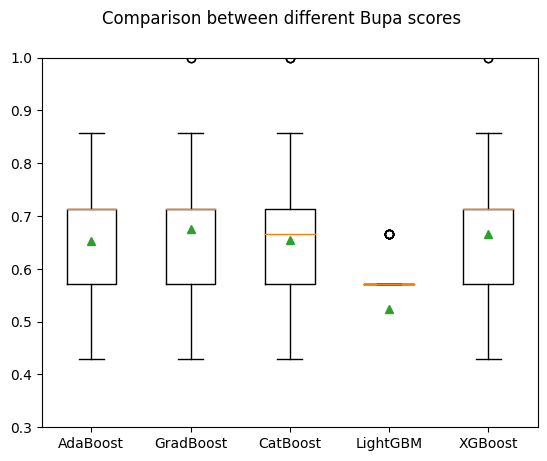

In [88]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Bupa scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(bupa_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [89]:
Algo_results['Bupa'] = bupa_mean

In [90]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,Bupa
0,AdaBoost,88.166667,97.082418,70.25,85.303571,65.190476
1,GradBoost,87.000000,96.434066,61.00,88.928571,67.619048
2,CatBoost,91.750000,98.258242,62.05,90.607143,65.380952
3,LightGBM,44.916667,55.824176,67.45,80.714286,52.380952
4,XGBoost,78.250000,98.412088,62.00,84.750000,66.619048


In [91]:
Algo_time_results['Bupa'] = pd.Series(execution_times)

---

# **Pima**

---

In [92]:
pima_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\AprendizadoDeMaquina\Seminario\Datasets\Pima\Diabetes.csv')

In [93]:
train_ratio = 0.6  # 60% for training
val_ratio = 0.2    # 20% for validation
test_ratio = 0.2   # 20% for testing

# First, split the data into training and temporary sets
temp_data, test_data = train_test_split(pima_df, test_size=test_ratio, random_state=42)

# Then, split the temporary data into training and validation sets
train_data, val_data = train_test_split(temp_data, test_size=val_ratio / (1 - test_ratio), random_state=42)

# Now, you have your training, validation, and test sets
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (460, 9)
Validation data shape: (154, 9)
Test data shape: (154, 9)


In [94]:
# Training
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
print(f"Training data shape: {X_train.shape, y_train.shape}")

# Validation
X_val = val_data.iloc[:, :-1]
y_val = val_data.iloc[:, -1]
print(f"Validation data shape: {X_val.shape, y_val.shape}")

# Test
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]
print(f"Test data shape: {X_test.shape, y_test.shape}")

Training data shape: ((460, 8), (460,))
Validation data shape: ((154, 8), (154,))
Test data shape: ((154, 8), (154,))


In [95]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)

In [96]:
# X = pima_df.iloc[:, :-1]
# y = pima_df.iloc[:, -1]

In [97]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

100%|██████████| 50/50 [01:24<00:00,  1.69s/trial, best loss: -0.7922077922077922]
Best hyperparameters for AdaBoost:
{'n_estimators': 850.0, 'learning_rate': 0.04142816402618046, 'max_depth': 5.0, 'max_features': None, 'min_samples_leaf': 2.0, 'min_samples_split': 8.0, 'random_state': 42}
100%|██████████| 50/50 [00:27<00:00,  1.79trial/s, best loss: -0.7857142857142857]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': None, 'n_estimators': 750, 'learning_rate': 0.09835742587463962, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 0.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [01:08<00:00,  1.37s/trial, best loss: -0.7922077922077922]
Best hyperparameters for CatBoost:
{'n_estimators': 300, 'learning_rate': 0.07188209594317357, 'min_child_samples': 2, 'max_depth': 6, 'reg_lambda': 0.3038873988970403, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 [00

In [99]:
pima_scores = []
pima_mean = []
pima_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)

    start_time = time.time()     
    results = cross_val_score(clf, X_test, y_test, cv=rskf)
    end_time = time.time()
    pima_scores.append(results)
    pima_mean.append(results.mean()*100)
    pima_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)
    print(f'--------- {algorithm_name} on Pima Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on Pima Dataset ---------
[0.6875     0.4375     0.75       0.625      0.86666667 0.53333333
 0.8        0.66666667 0.8        0.86666667 0.8125     0.5625
 0.625      0.75       0.6        0.93333333 0.66666667 0.8
 0.6        0.73333333 0.8125     0.75       0.75       0.6875
 0.8        0.66666667 0.73333333 0.46666667 0.86666667 0.26666667
 0.6875     0.8125     0.75       0.5625     0.66666667 0.8
 0.8        0.73333333 0.86666667 0.66666667 0.75       0.8125
 0.75       0.875      0.66666667 0.6        0.8        0.66666667
 0.53333333 0.66666667 0.6875     0.625      0.75       0.6875
 0.8        0.53333333 0.8        0.86666667 0.53333333 0.8
 0.625      0.8125     0.8125     0.6875     0.6        0.73333333
 0.66666667 0.8        0.6        0.53333333 0.5        0.75
 0.5625     0.625      0.86666667 0.66666667 0.8        0.73333333
 0.73333333 0.8        0.8125     0.75       0.75       0.75
 0.8        0.73333333 0.53333333 0.73333333 0.66666667 0.73333333

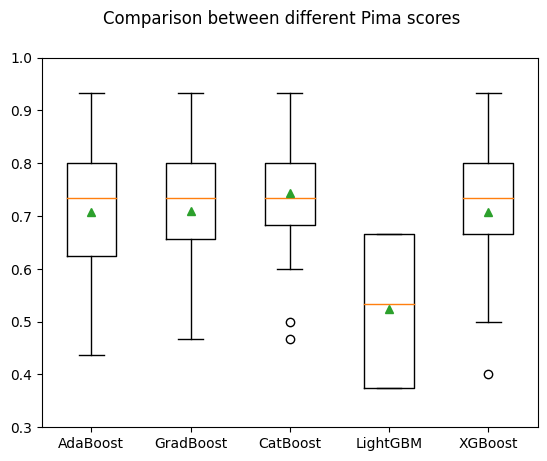

In [100]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Pima scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(pima_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [101]:
Algo_results['Pima'] = pima_mean

In [102]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,Bupa,Pima
0,AdaBoost,88.166667,97.082418,70.25,85.303571,65.190476,70.733333
1,GradBoost,87.000000,96.434066,61.00,88.928571,67.619048,71.004167
2,CatBoost,91.750000,98.258242,62.05,90.607143,65.380952,74.283333
3,LightGBM,44.916667,55.824176,67.45,80.714286,52.380952,52.333333
4,XGBoost,78.250000,98.412088,62.00,84.750000,66.619048,70.854167


In [103]:
Algo_time_results['Pima'] = pd.Series(execution_times)

---

# **Heart**

---

In [104]:
heart_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\AprendizadoDeMaquina\Seminario\Datasets\Heart\Heart.csv')

In [105]:
train_ratio = 0.6  # 60% for training
val_ratio = 0.2    # 20% for validation
test_ratio = 0.2   # 20% for testing

# First, split the data into training and temporary sets
temp_data, test_data = train_test_split(heart_df, test_size=test_ratio, random_state=42)

# Then, split the temporary data into training and validation sets
train_data, val_data = train_test_split(temp_data, test_size=val_ratio / (1 - test_ratio), random_state=42)

# Now, you have your training, validation, and test sets
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (162, 14)
Validation data shape: (54, 14)
Test data shape: (54, 14)


In [106]:
# Training
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
print(f"Training data shape: {X_train.shape, y_train.shape}")

# Validation
X_val = val_data.iloc[:, :-1]
y_val = val_data.iloc[:, -1]
print(f"Validation data shape: {X_val.shape, y_val.shape}")

# Test
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]
print(f"Test data shape: {X_test.shape, y_test.shape}")

Training data shape: ((162, 13), (162,))
Validation data shape: ((54, 13), (54,))
Test data shape: ((54, 13), (54,))


In [107]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)

In [108]:
# X = heart_df.iloc[:, :-1]
# y = heart_df.iloc[:, -1]

In [109]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

# le = LabelEncoder()
# y = le.fit_transform(y)

In [110]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

100%|██████████| 50/50 [00:51<00:00,  1.02s/trial, best loss: -0.8148148148148148]
Best hyperparameters for AdaBoost:
{'n_estimators': 600.0, 'learning_rate': 0.03167747886969513, 'max_depth': 1.0, 'max_features': None, 'min_samples_leaf': 3.0, 'min_samples_split': 4.0, 'random_state': 42}
100%|██████████| 50/50 [00:17<00:00,  2.84trial/s, best loss: -0.8148148148148148]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.04102652661864284, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0, 'min_impurity_decrease': 1.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [00:51<00:00,  1.04s/trial, best loss: -0.8148148148148148]
Best hyperparameters for CatBoost:
{'n_estimators': 750, 'learning_rate': 0.02983152512960275, 'min_child_samples': 3, 'max_depth': 5, 'reg_lambda': 3.8771604915102147, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 [0

In [112]:
heart_scores = []
heart_mean = []
heart_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)

    start_time = time.time()    
    results = cross_val_score(clf, X_test, y_test, cv=rskf)
    end_time = time.time()
    heart_scores.append(results)
    heart_mean.append(results.mean()*100)
    heart_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)
    print(f'--------- {algorithm_name} on Heart Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on Heart Dataset ---------
[0.83333333 0.66666667 1.         0.83333333 0.8        0.8
 0.6        0.8        1.         0.6        0.66666667 0.83333333
 0.66666667 0.66666667 0.8        0.8        0.6        1.
 1.         0.6        0.83333333 0.66666667 0.83333333 0.5
 0.8        0.6        0.4        1.         0.8        1.
 0.83333333 0.66666667 0.66666667 1.         0.8        0.8
 1.         0.8        0.8        0.6        0.66666667 1.
 0.33333333 0.83333333 0.6        0.8        0.6        0.8
 0.8        0.8        1.         0.83333333 0.66666667 0.66666667
 1.         0.8        0.4        0.8        0.6        0.6
 1.         0.66666667 0.83333333 1.         0.4        0.8
 0.6        0.4        0.6        1.         0.5        0.83333333
 0.83333333 0.66666667 0.8        0.6        0.8        1.
 0.8        0.6        0.83333333 0.5        0.66666667 0.83333333
 0.8        0.8        0.8        0.4        0.8        0.8
 0.66666667 0.83333333 0.83333

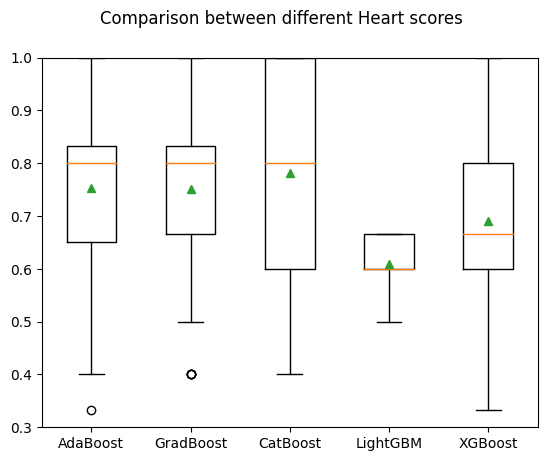

In [113]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Heart scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(heart_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [114]:
Algo_results['Heart'] = heart_mean

In [115]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,Bupa,Pima,Heart
0,AdaBoost,88.166667,97.082418,70.25,85.303571,65.190476,70.733333,75.266667
1,GradBoost,87.000000,96.434066,61.00,88.928571,67.619048,71.004167,75.100000
2,CatBoost,91.750000,98.258242,62.05,90.607143,65.380952,74.283333,78.166667
3,LightGBM,44.916667,55.824176,67.45,80.714286,52.380952,52.333333,61.000000
4,XGBoost,78.250000,98.412088,62.00,84.750000,66.619048,70.854167,69.033333


In [116]:
Algo_time_results['Heart'] = pd.Series(execution_times)

---

# **Liver**

---

In [117]:
liver_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\AprendizadoDeMaquina\Seminario\Datasets\Liver\Liver.data', header=None)

In [118]:
train_ratio = 0.6  # 60% for training
val_ratio = 0.2    # 20% for validation
test_ratio = 0.2   # 20% for testing

# First, split the data into training and temporary sets
temp_data, test_data = train_test_split(liver_df, test_size=test_ratio, random_state=42)

# Then, split the temporary data into training and validation sets
train_data, val_data = train_test_split(temp_data, test_size=val_ratio / (1 - test_ratio), random_state=42)

# Now, you have your training, validation, and test sets
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (207, 7)
Validation data shape: (69, 7)
Test data shape: (69, 7)


In [119]:
# Training
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
print(f"Training data shape: {X_train.shape, y_train.shape}")

# Validation
X_val = val_data.iloc[:, :-1]
y_val = val_data.iloc[:, -1]
print(f"Validation data shape: {X_val.shape, y_val.shape}")

# Test
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]
print(f"Test data shape: {X_test.shape, y_test.shape}")

Training data shape: ((207, 6), (207,))
Validation data shape: ((69, 6), (69,))
Test data shape: ((69, 6), (69,))


In [120]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)

In [121]:
# X = liver_df.iloc[:, :-1]
# y = liver_df.iloc[:, -1]

In [122]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

# le = LabelEncoder()
# y = le.fit_transform(y)

In [123]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [124]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return -accuracy_score(y_val, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

100%|██████████| 50/50 [00:41<00:00,  1.21trial/s, best loss: -0.7681159420289855]
Best hyperparameters for AdaBoost:
{'n_estimators': 200.0, 'learning_rate': 0.028745858811684347, 'max_depth': 2.0, 'max_features': 'log2', 'min_samples_leaf': 2.0, 'min_samples_split': 8.0, 'random_state': 42}
100%|██████████| 50/50 [00:13<00:00,  3.65trial/s, best loss: -0.7681159420289855]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.04102652661864284, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0, 'min_impurity_decrease': 1.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [00:50<00:00,  1.01s/trial, best loss: -0.782608695652174] 
Best hyperparameters for CatBoost:
{'n_estimators': 500, 'learning_rate': 0.01002981253798441, 'min_child_samples': 2, 'max_depth': 10, 'reg_lambda': 2.6701577095887252, 'silent': True, 'random_state': 42}
100%|██████████| 50/5

In [125]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [126]:
liver_scores = []
liver_mean = []
liver_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)

    start_time = time.time()    
    results = cross_val_score(clf, X_test, y_test, cv=rskf)
    end_time = time.time()
    liver_scores.append(results)
    liver_mean.append(results.mean()*100)
    liver_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)
    print(f'--------- {algorithm_name} on Liver Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on Liver Dataset ---------
[0.57142857 0.57142857 0.28571429 0.71428571 0.71428571 0.71428571
 0.28571429 0.57142857 0.85714286 0.66666667 0.71428571 0.57142857
 0.71428571 0.71428571 0.71428571 0.71428571 0.42857143 0.85714286
 0.28571429 0.66666667 0.57142857 0.42857143 0.57142857 0.85714286
 0.57142857 0.71428571 0.57142857 0.71428571 0.57142857 0.66666667
 0.57142857 0.85714286 0.57142857 0.71428571 0.57142857 0.71428571
 0.71428571 0.42857143 0.71428571 0.83333333 0.57142857 0.71428571
 0.57142857 0.85714286 0.42857143 0.71428571 0.57142857 0.57142857
 0.57142857 0.83333333 0.57142857 0.85714286 0.57142857 0.85714286
 0.71428571 0.85714286 0.57142857 0.85714286 0.42857143 0.5
 0.71428571 0.42857143 0.85714286 0.57142857 0.71428571 0.57142857
 0.71428571 0.57142857 0.71428571 0.83333333 0.71428571 0.85714286
 0.57142857 0.85714286 0.42857143 0.85714286 0.42857143 0.71428571
 0.71428571 0.66666667 0.57142857 0.71428571 0.85714286 0.57142857
 0.71428571 0.85714286 

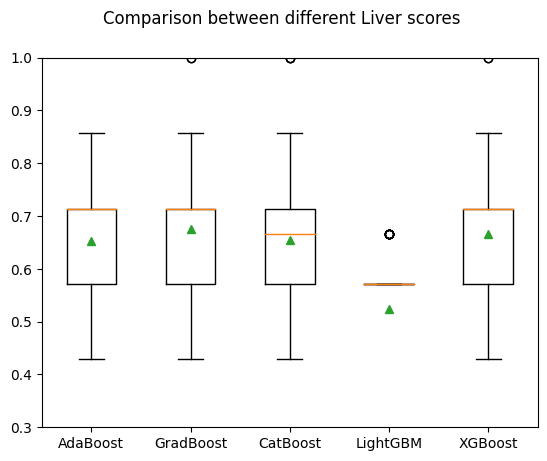

In [127]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Liver scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(liver_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [128]:
Algo_results['Liver'] = liver_mean

In [129]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,Bupa,Pima,Heart,Liver
0,AdaBoost,88.166667,97.082418,70.25,85.303571,65.190476,70.733333,75.266667,65.190476
1,GradBoost,87.000000,96.434066,61.00,88.928571,67.619048,71.004167,75.100000,67.619048
2,CatBoost,91.750000,98.258242,62.05,90.607143,65.380952,74.283333,78.166667,65.380952
3,LightGBM,44.916667,55.824176,67.45,80.714286,52.380952,52.333333,61.000000,52.380952
4,XGBoost,78.250000,98.412088,62.00,84.750000,66.619048,70.854167,69.033333,66.619048


In [130]:
Tuned_Algo_results_tr = Algo_results.set_index('Names').T

In [132]:
Tuned_Algo_results_tr.to_csv('E:\Cursos\MestradoCienciaComputação\AprendizadoDeMaquina\Seminario\Code\AlgorithmComparison\AlgorithmComparison\TunedAlgoResults.csv', index=False)

In [133]:
Tuned_Algo_results_tr

Names,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
Wine,88.166667,87.000000,91.750000,44.916667,78.250000
Breast_Cancer,97.082418,96.434066,98.258242,55.824176,98.412088
Sonar,70.250000,61.000000,62.050000,67.450000,62.000000
Ionosphere,85.303571,88.928571,90.607143,80.714286,84.750000
Bupa,65.190476,67.619048,65.380952,52.380952,66.619048
Pima,70.733333,71.004167,74.283333,52.333333,70.854167
Heart,75.266667,75.100000,78.166667,61.000000,69.033333
Liver,65.190476,67.619048,65.380952,52.380952,66.619048


In [134]:
Algo_time_results['Liver'] = pd.Series(execution_times)

In [135]:
Algo_time_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,Bupa,Pima,Heart,Liver
0,AdaBoost,1.013227,34.874733,172.098242,146.819920,22.174649,151.680956,66.337747,22.492951
1,GradBoost,98.996717,12.208340,49.973433,86.928549,3.489784,45.408070,3.617876,3.512265
2,CatBoost,53.566599,270.585441,67.879931,65.282004,141.794038,48.567595,87.458145,143.050683
3,LightGBM,0.755169,0.595133,1.031106,1.427489,0.559126,0.566139,0.581154,0.584130
4,XGBoost,17.993899,10.222295,4.016673,11.443568,2.322521,11.136394,2.121266,2.370531


In [136]:
Tuned_Algo_time_results_tr = Algo_time_results.set_index('Names').T

In [138]:
Tuned_Algo_time_results_tr.to_csv('E:\Cursos\MestradoCienciaComputação\AprendizadoDeMaquina\Seminario\Code\AlgorithmComparison\AlgorithmComparison\TunedAlgoTimeResults.csv', index=False)

---

# **Friedman's Test**

---

In [139]:
!pip install scikit-posthocs

In [140]:
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare

In [142]:
Tuned_Algo_results_tr = pd.read_csv('E:\Cursos\MestradoCienciaComputação\AprendizadoDeMaquina\Seminario\Code\AlgorithmComparison\AlgorithmComparison\TunedAlgoResults.csv')

In [143]:
Tuned_Algo_results_tr

,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
0,88.166667,87.000000,91.750000,44.916667,78.250000
1,97.082418,96.434066,98.258242,55.824176,98.412088
2,70.250000,61.000000,62.050000,67.450000,62.000000
3,85.303571,88.928571,90.607143,80.714286,84.750000
4,65.190476,67.619048,65.380952,52.380952,66.619048
5,70.733333,71.004167,74.283333,52.333333,70.854167
6,75.266667,75.100000,78.166667,61.000000,69.033333
7,65.190476,67.619048,65.380952,52.380952,66.619048


In [144]:
stat, p_value = friedmanchisquare(Tuned_Algo_results_tr['AdaBoost'], Tuned_Algo_results_tr['GradBoost'], Tuned_Algo_results_tr['CatBoost'], Tuned_Algo_results_tr['LightGBM'], Tuned_Algo_results_tr['XGBoost'])

In [145]:
p_value

0.01127579394733179

In [146]:
alpha = 0.05
if p_value < alpha:
    print('There are significant differences among the models.')
else:
    print('There are no significant differences among the models.')

There are significant differences among the models.


---

# **Nemenyi test**

---

In [149]:
nemenyi_results = sp.posthoc_nemenyi_friedman(a=Tuned_Algo_results_tr)

In [150]:
nemenyi_results

,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
AdaBoost,1.000000,0.900000,0.687481,0.174719,0.900000
GradBoost,0.900000,1.000000,0.866947,0.084282,0.900000
CatBoost,0.687481,0.866947,1.000000,0.004591,0.597744
LightGBM,0.174719,0.084282,0.004591,1.000000,0.239603
XGBoost,0.900000,0.900000,0.597744,0.239603,1.000000


In [151]:
alpha = 0.05

# Print p-values for all pairs of models
for i in range(nemenyi_results.shape[0]):
    for j in range(i + 1, nemenyi_results.shape[1]):
        model1 = i + 1
        model2 = j + 1
        p_value = nemenyi_results.iloc[i, j]

        if p_value < alpha:
            print(f"Models {model1} and {model2} are significantly different (p-value = {p_value:.4f}).")
        else:
            print(f"Models {model1} and {model2} are not significantly different (p-value = {p_value:.4f}).")

Models 1 and 2 are not significantly different (p-value = 0.9000).
Models 1 and 3 are not significantly different (p-value = 0.6875).
Models 1 and 4 are not significantly different (p-value = 0.1747).
Models 1 and 5 are not significantly different (p-value = 0.9000).
Models 2 and 3 are not significantly different (p-value = 0.8669).
Models 2 and 4 are not significantly different (p-value = 0.0843).
Models 2 and 5 are not significantly different (p-value = 0.9000).
Models 3 and 4 are significantly different (p-value = 0.0046).
Models 3 and 5 are not significantly different (p-value = 0.5977).
Models 4 and 5 are not significantly different (p-value = 0.2396).


---

# **Algorithms running time Friedman's Test**

---

In [152]:
Tuned_Algo_results_tr = pd.read_csv('E:\Cursos\MestradoCienciaComputação\AprendizadoDeMaquina\Seminario\Code\AlgorithmComparison\AlgorithmComparison\TunedAlgoTimeResults.csv')

In [153]:
Tuned_Algo_results_tr

,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
0,1.013227,98.996717,53.566599,0.755169,17.993899
1,34.874733,12.208340,270.585441,0.595133,10.222295
2,172.098242,49.973433,67.879931,1.031106,4.016673
3,146.819920,86.928549,65.282004,1.427489,11.443568
4,22.174649,3.489784,141.794038,0.559126,2.322521
5,151.680956,45.408070,48.567595,0.566139,11.136394
6,66.337747,3.617876,87.458145,0.581154,2.121266
7,22.492951,3.512265,143.050683,0.584130,2.370531


In [154]:
stat, p_value = friedmanchisquare(Tuned_Algo_results_tr['AdaBoost'], Tuned_Algo_results_tr['GradBoost'], Tuned_Algo_results_tr['CatBoost'], Tuned_Algo_results_tr['LightGBM'], Tuned_Algo_results_tr['XGBoost'])

In [155]:
p_value

3.472289952954606e-05

In [156]:
alpha = 0.05
if p_value < alpha:
    print('There are significant running time differences among the algorithm.')
else:
    print('There are no significant running time differences among the algorithm.')

There are significant running time differences among the algorithm.


---

# **Algorithms running time Nemenyi test**

---

In [157]:
nemenyi_results = sp.posthoc_nemenyi_friedman(a=Tuned_Algo_results_tr)

In [158]:
nemenyi_results

,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
AdaBoost,1.000000,0.866947,0.900000,0.001000,0.084282
GradBoost,0.866947,1.000000,0.687481,0.022374,0.508007
CatBoost,0.900000,0.687481,1.000000,0.001000,0.035854
LightGBM,0.001000,0.022374,0.001000,1.000000,0.597744
XGBoost,0.084282,0.508007,0.035854,0.597744,1.000000


In [159]:
alpha = 0.05

# Print p-values for all pairs of models
for i in range(nemenyi_results.shape[0]):
    for j in range(i + 1, nemenyi_results.shape[1]):
        model1 = i + 1
        model2 = j + 1
        p_value = nemenyi_results.iloc[i, j]

        if p_value < alpha:
            print(f"Algorithm {model1} and {model2} are significantly different (p-value = {p_value:.4f}).")
        else:
            print(f"Algorithm {model1} and {model2} are not significantly different (p-value = {p_value:.4f}).")

Algorithm 1 and 2 are not significantly different (p-value = 0.8669).
Algorithm 1 and 3 are not significantly different (p-value = 0.9000).
Algorithm 1 and 4 are significantly different (p-value = 0.0010).
Algorithm 1 and 5 are not significantly different (p-value = 0.0843).
Algorithm 2 and 3 are not significantly different (p-value = 0.6875).
Algorithm 2 and 4 are significantly different (p-value = 0.0224).
Algorithm 2 and 5 are not significantly different (p-value = 0.5080).
Algorithm 3 and 4 are significantly different (p-value = 0.0010).
Algorithm 3 and 5 are significantly different (p-value = 0.0359).
Algorithm 4 and 5 are not significantly different (p-value = 0.5977).
